In [333]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

from PIL import Image

In [334]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device}")

Using cuda


In [335]:
from ultralytics import YOLO
yolo_model = YOLO("yolov8n.pt")
yolo_model = yolo_model.model.model[:10]
yolo_model = yolo_model.to(device)
yolo_model.eval()
print(yolo_model)

Sequential(
  (0): Conv(
    (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (1): Conv(
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (2): C2f(
    (cv1): Conv(
      (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (cv2): Conv(
      (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (m): ModuleList(
      (0): Bottleneck(
        (cv1): Conv(
        

In [336]:
# Extract features from images
features = {}
directory = 'Images'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

for img_name in tqdm(os.listdir(directory)):
    img_path = os.path.join(directory, img_name)
    image = Image.open(img_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    feature = yolo_model(image)
    feature = feature.view(feature.size(0), -1).detach().cpu().numpy()[0]
    image_id = img_name.split('.')[0]
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [337]:
# Store features in pickle
with open(os.path.join('./', 'features.pkl'), 'wb') as f:
    pickle.dump(features, f)

In [338]:
# Load features from pickle
with open(os.path.join('./', 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [339]:
print(features['3250076419_eb3de15063'])
print(features['3747543364_bf5b548527'])

print(features['3250076419_eb3de15063'].shape)
print(len(features))
feature_size = features['3250076419_eb3de15063'].shape[0]

[    0.27217      0.1477     0.19528 ...    -0.27595    -0.26205    -0.26939]
[    0.45006     0.44025     0.38045 ...    -0.15023    -0.10277   -0.084997]
(12544,)
8091


In [340]:
# Load captions from the text file
with open(os.path.join('./', 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [341]:
# Create mapping of image to captions
mapping = {}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [342]:
# Clean the captions
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [343]:
# Before preprocess of text
print(mapping['1000268201_693b08cb0e'])

['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


In [344]:
# Preprocess the text
clean(mapping)

# After preprocess of text
print(mapping['1000268201_693b08cb0e'])

['startseq child in pink dress is climbing up set of stairs in an entry way endseq', 'startseq girl going into wooden building endseq', 'startseq little girl climbing into wooden playhouse endseq', 'startseq little girl climbing the stairs to her playhouse endseq', 'startseq little girl in pink dress going into wooden cabin endseq']


In [345]:
all_captions = [caption for captions in mapping.values() for caption in captions]
len(all_captions)

40455

In [346]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [347]:
import torchtext
from torchtext.data import get_tokenizer

tokenizer = get_tokenizer("basic_english")

# Tokenize the text
tokenized_text = [tokenizer(caption) for caption in all_captions]

vocab = torchtext.vocab.build_vocab_from_iterator(tokenized_text)
vocab_size = len(vocab)
print(vocab_size)

8896


In [415]:
print(vocab['you'])

1377


In [349]:
max_length = max(len(caption.split()) for caption in all_captions)
print(max_length)

35


In [350]:
image_ids = list(mapping.keys())
split = int(len(image_ids)*0.75)
train = image_ids[:split]
test = image_ids[split:]

In [351]:
def one_hot(a, num_classes):
    out = np.zeros(num_classes)
    out[a] = 1
    return out
    

In [387]:
class CaptionDataset(Dataset):
    def __init__(self, data_keys, mapping, features, tokenizer, max_length):
        self.data_keys = data_keys
        self.mapping = mapping
        self.features = features
        self.tokenizer = tokenizer
        self.max_length = max_length
        

    def __len__(self):
        return len(self.data_keys)

    def __getitem__(self, idx):
        key = self.data_keys[idx]
        captions = self.mapping[key]

        # caption = captions[np.random.choice(len(captions))]
        caption = captions[0]
        input1, input2, y = torch.zeros((1, feature_size)), torch.zeros(max_length).int(), torch.zeros((max_length, vocab_size))
        input1[0] = torch.as_tensor(features[key])
        tokens = self.tokenizer(caption)
        caption_indices = [vocab[token] for token in tokens]

        for i in range(1, len(caption_indices)):
            in_seq, out_seq = caption_indices[i-1], caption_indices[i]

            out_seq = int(out_seq)
            out_seq = one_hot(out_seq, num_classes=vocab_size)
         
            input2[i-1] = int(in_seq)

            y[i-1] = torch.as_tensor(out_seq)

        return input1, input2, y, idx


In [416]:
batch_size = 32
train_dataset = CaptionDataset(train, mapping, features, tokenizer, max_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [417]:
print(train_dataset.__getitem__(0)[0].size())
print(train_dataset.__getitem__(0)[1].size())
print(train_dataset.__getitem__(0)[2].size())

torch.Size([1, 12544])
torch.Size([35])
torch.Size([35, 8896])


In [418]:
class Encoder(nn.Module) :
    def __init__(self, feature_size, hidden_size) :
        super(Encoder, self).__init__()
        self.image_feature_layer = nn.Sequential(
            # nn.Dropout(0.4),
            nn.Linear(feature_size, 4096),
            nn.ReLU(),
            nn.Linear(4096, hidden_size),   
            nn.ReLU()
        )

    def forward(self, image_input) :
        return self.image_feature_layer(image_input) 


class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(Decoder, self).__init__()
        
        self.emb = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        self.lstm = nn.LSTM(embedding_size, hidden_size, batch_first=True)
        
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, vocab_size),
            # nn.ReLU()
        )

    def forward(self, sequence_input, h, c):
        se = self.emb(sequence_input)
        
        output, (h, c) = self.lstm(se, (h, c))

        output = self.decoder(output)

        return output, h, c
    

class ImageCaptioningModel(nn.Module) :
    def __init__(self, feature_size, vocab_size, embedding_size, hidden_size):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = Encoder(feature_size, hidden_size)
        self.decoder = Decoder(vocab_size, embedding_size, hidden_size)

    def forward(self, image_input, sequence_input, h=None, c=None) :
        fe = self.encoder(image_input)
        c = None
        if h is None :
            if len(fe.size()) == 3 :
                fe = fe.permute(1, 0, 2)
                c = torch.randn(1, fe.shape[1], 256).to(device)
            else : 
                c = torch.randn(1, 256).to(device) 
            return self.decoder(sequence_input, fe, c)
        
        c = torch.randn(1, 256).to(device) 
        return self.decoder(sequence_input, h, c)

In [466]:
# Instantiate the model
embedding_size = 256
hidden_size = 256

model = ImageCaptioningModel(feature_size, vocab_size, embedding_size, hidden_size)
model = model.to(device)

In [467]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [421]:
data_iter = iter(train_loader)
single_batch = next(data_iter)

In [468]:
num_epochs = 500
for epoch in range(num_epochs) :
    total_loss = 0
    model.train()
    inputs1, inputs2, targets, _ = single_batch

    inputs1, inputs2, targets = inputs1.to(device), inputs2.to(device), targets.to(device)
    hidden, c = None, None
    output, hidden, c = model(inputs1, inputs2, hidden, c)

    # mask = torch.logical_not(torch.eq(targets, torch.zeros_like(targets)))
    # loss = criterion(output[mask], targets[mask])
    mask = torch.sum(targets, dim=-1) != 0
    output_flat = output.view(-1, vocab_size)
    targets_flat = targets.view(-1, vocab_size)

    # Apply the mask
    output_masked = output_flat[mask.view(-1)]
    targets_masked = targets_flat[mask.view(-1)]
    loss = criterion(output_masked, targets_masked)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss:.4f}')

Epoch [1/500], Loss: 9.0963
Epoch [2/500], Loss: 9.0466
Epoch [3/500], Loss: 8.9940
Epoch [4/500], Loss: 8.9284
Epoch [5/500], Loss: 8.8510
Epoch [6/500], Loss: 8.7579
Epoch [7/500], Loss: 8.6385
Epoch [8/500], Loss: 8.4853
Epoch [9/500], Loss: 8.2745
Epoch [10/500], Loss: 7.9873
Epoch [11/500], Loss: 7.5683
Epoch [12/500], Loss: 6.9910
Epoch [13/500], Loss: 6.1570
Epoch [14/500], Loss: 5.2640
Epoch [15/500], Loss: 4.7919
Epoch [16/500], Loss: 4.7612
Epoch [17/500], Loss: 4.7339
Epoch [18/500], Loss: 4.6217
Epoch [19/500], Loss: 4.4860
Epoch [20/500], Loss: 4.3792
Epoch [21/500], Loss: 4.2930
Epoch [22/500], Loss: 4.2163
Epoch [23/500], Loss: 4.1472
Epoch [24/500], Loss: 4.0754
Epoch [25/500], Loss: 4.0093
Epoch [26/500], Loss: 3.9376
Epoch [27/500], Loss: 3.8691
Epoch [28/500], Loss: 3.7813
Epoch [29/500], Loss: 3.7028
Epoch [30/500], Loss: 3.6276
Epoch [31/500], Loss: 3.5415
Epoch [32/500], Loss: 3.4531
Epoch [33/500], Loss: 3.3714
Epoch [34/500], Loss: 3.2912
Epoch [35/500], Loss: 3

In [423]:
# # Train the model
# num_epochs = 50
                                                               
# for epoch in range(num_epochs):
#     total_loss = 0
#     model.train()

#     for batch in train_loader:
#         inputs1, inputs2, targets = batch

#         inputs1, inputs2, targets = inputs1.to(device), inputs2.to(device), targets.to(device)
#         hidden, c = None, None
#         output, hidden, c = model(inputs1, inputs2, hidden, c)

#         # Calculate the loss
#         loss = criterion(output, targets)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()
#     # break
#     average_loss = total_loss / len(train_loader)
#     print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}')

In [424]:
# # Save the model
# torch.save(model.state_dict(), os.path.join('./', 'best_model.pth'))

In [445]:
# Evaluation
def idx_to_word(index):
    try:
        return vocab.get_itos()[index]
    except:
        return None

def predict_caption(model, feature, max_length):
    model.eval()
    input1 = torch.zeros((1, feature_size)).to(device)
    input1[0] = torch.as_tensor(feature)
    hidden = None
    c = None 
    input2 = torch.zeros(1).int()
    in_text = 'startseq'
    for _ in range(max_length):
        input2[0] = torch.as_tensor(vocab[in_text.split(' ')[-1]], dtype=torch.int64)
        input2 = input2.to(device)

        outputs, hidden, c = model(input1, input2, hidden, c)

        outputs = F.softmax(outputs, dim=1)

        # y_pred = torch.argmax(outputs, dim=1).squeeze(0).item()
        y_pred = torch.multinomial(outputs, 1).squeeze(0).item()
        
        word = idx_to_word(y_pred)
        in_text += ' ' + word
        
        if word is None or word == 'endseq' :
            break

    return in_text



In [426]:
# BLEU Score Calculation
from nltk.translate.bleu_score import corpus_bleu

actual, predicted = [], []

for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], max_length)
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)

# Calculate BLEU score
bleu1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
bleu2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))

print(f"BLEU-1: {bleu1}")
print(f"BLEU-2: {bleu2}")


  0%|          | 0/2023 [00:00<?, ?it/s]

BLEU-1: 0.0450963585589073
BLEU-2: 0.01342493711387129


In [446]:
_, _, _, ids = single_batch
print(ids)

tensor([2122, 1300, 5130, 2325,  564, 2280, 1908, 1664, 5643, 1989, 4984, 1884, 1467, 3913, 2639, 5573, 4110, 4294,   58, 2857, 3507, 5524, 2902, 4716,  354, 2977, 2806, 5829, 3253, 2727, 5832,  541])


In [447]:
# Generate caption for an image
def generate_caption(image_name) :
    image_id = image_name.split('.')[0]
    img_path = os.path.join('./', "Images", image_name)
    image = Image.open(img_path)

    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)

    y_pred = predict_caption(model, features[image_id], max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)

    plt.imshow(image)

---------------------Actual---------------------
startseq dog with frisbee in front of brown dog endseq
startseq large black dog is catching frisbee while large brown dog follows shortly after endseq
startseq two dark colored dogs romp in the grass with blue frisbee endseq
startseq two dogs are catching blue frisbees in grass endseq
startseq two dogs are playing one is catching frisbee endseq
--------------------Predicted--------------------
startseq dog the camera endseq
None


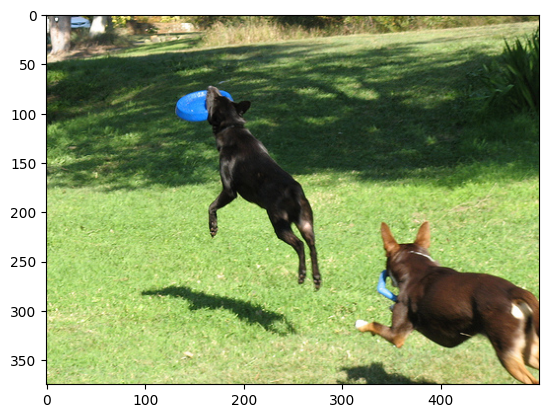

In [469]:
print(generate_caption(f'{train[2122]}.jpg'))

---------------------Actual---------------------
startseq four people are lining up to purchase tickets at the theater endseq
startseq four people standing outside of an outdoor ticket booth endseq
startseq four people wait outside in line for ticket endseq
startseq the man and woman at the window are turned around to the man and woman behind them endseq
startseq two men and two women standing at the window of ticket booth endseq
--------------------Predicted--------------------
startseq four human figures are jumping around outdoors more hiking pub fort experiences ruin indoor stays whil different path dirt safari wrestled roofed proped breezeway shake rabbit headphone remove roads up trade hotrod roller-coaster slouched gambling
None


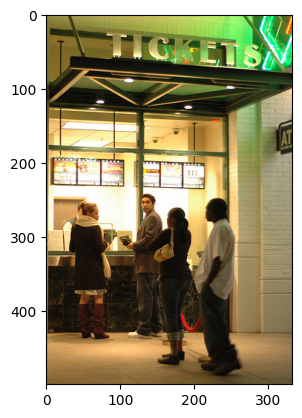

In [470]:
print(generate_caption(f'{train[1300]}.jpg'))

---------------------Actual---------------------
startseq woman shows off newborn baby to young boy and girl endseq
startseq woman holding baby with two children around her endseq
startseq two children and an adult admire newborn baby held by the adult endseq
startseq "two women little boy and baby ." endseq
startseq woman holding baby and young girl and boy look on endseq
--------------------Predicted--------------------
startseq woman shows off sitting chair endseq
None


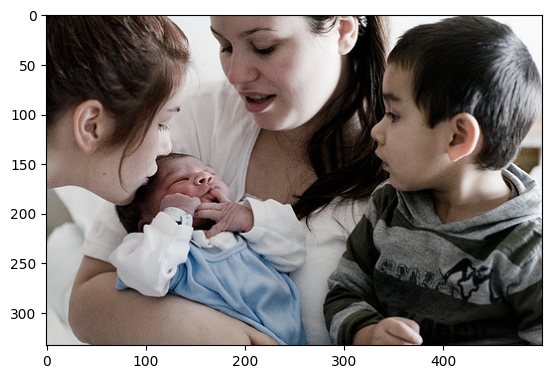

In [471]:
print(generate_caption(f'{train[5130]}.jpg'))

---------------------Actual---------------------
startseq brunette woman in blue shirt too small for her standing behind casually-dressed people endseq
startseq woman in blue shirt in crowd endseq
startseq woman in blue shirt standing in crowd of people endseq
startseq woman in blue striped shirt with her hands on her hips in crowd of people endseq
startseq woman wearing shirt that has risen up from the waist of her jeans endseq
--------------------Predicted--------------------
startseq brunette woman in swimming pool and girl in blue sky . bartender scent ledge expanse technical man use coaster eating leaped group of walk around bmx riders bubbles standing blacktop rail front of ball look
None


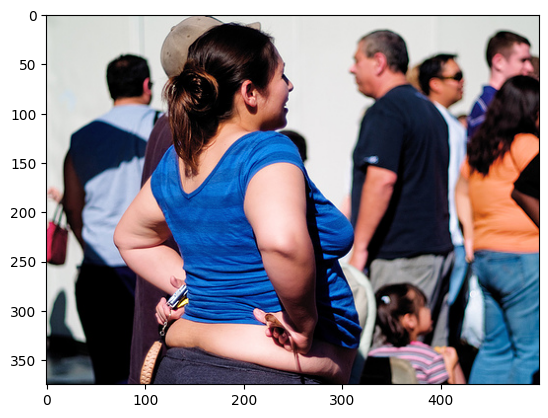

In [472]:
print(generate_caption(f'{train[564]}.jpg'))